## Pseudocode of an RNN
```py
state_t = 0
for input_t in input_sequence:
    output_t = f(input_t, state_t)
    state_t = output_t
```

### Understanding the function

(W and U are weight matrices, b is the bias vector)

```py
state_t = 0
for input_t in input_sequence:
    output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
    state_t = output_t
```

In [4]:
# A naive Numpy implementation of RNN
import numpy as np
timesteps = 100
input_features = 32
output_features = 64

inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.concatenate(successive_outputs, axis=0)

In [5]:
# Using SimpleRNN in Keras: the intermediate layers return the entire sequence of outputs for later layers to be able to train on them
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32), return_sequences=True)
model.add(SimpleRNN(32), return_sequences=True)
model.add(SimpleRNN(32))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Preparing data
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
maxlen = 500
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


In [11]:
# Training a SimpleRNN model with one recurrent layer + embedding
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 34s 219ms/step - loss: 0.6622 - acc: 0.5892 - val_loss: 0.5331 - val_acc: 0.7710
Epoch 2/10
157/157 [==============================] - 38s 241ms/step - loss: 0.4152 - acc: 0.8231 - val_loss: 0.4477 - val_acc: 0.8026
Epoch 3/10
157/157 [==============================] - 35s 221ms/step - loss: 0.2843 - acc: 0.8849 - val_loss: 0.5544 - val_acc: 0.7716
Epoch 4/10
157/157 [==============================] - 32s 202ms/step - loss: 0.2066 - acc: 0.9200 - val_loss: 0.4421 - val_acc: 0.8024
Epoch 5/10
157/157 [==============================] - 33s 209ms/step - loss: 0.1400 - acc: 0.9494 - val_loss: 0.4657 - val_acc: 0.8494
Epoch 6/10
157/157 [==============================] - 42s 266ms/step - loss: 0.0820 - acc: 0.9740 - val_loss: 0.5514 - val_acc: 0.7928
Epoch 7/10
157/157 [==============================] - 40s 254ms/step - loss: 0.0462 - acc: 0.9856 - val_loss: 0.5611 - val_acc: 0.8298
Epoch 8/10
157/157 [==============================] - 3

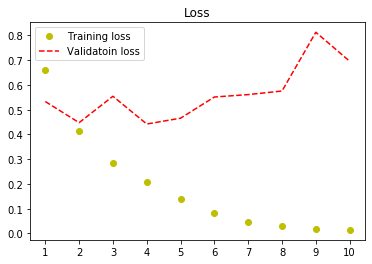

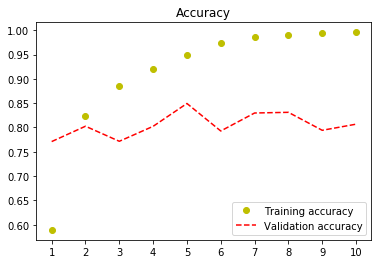

In [12]:
from util import plot_history
plot_history(history)

The SimpleRNN got bad results compared to the previous model with embedding. The problem is that SimpleRNN suffers from vanishing gradient. LSTMs solve this problem "transporting" some data into a later point. The transported data is computed by three different set of operations with different trainable matrices and input and state values.

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
157/157 [==============================] - 78s 496ms/step - loss: 0.5125 - acc: 0.7595 - val_loss: 0.4302 - val_acc: 0.8096
Epoch 2/10
157/157 [==============================] - 78s 497ms/step - loss: 0.3032 - acc: 0.8791 - val_loss: 0.3732 - val_acc: 0.8336
Epoch 3/10
157/157 [==============================] - 79s 502ms/step - loss: 0.2369 - acc: 0.9112 - val_loss

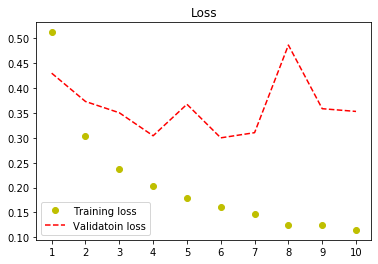

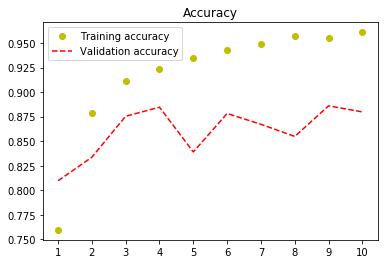

In [14]:
# Trying with LSTM
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()
history = model.fit(input_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

plot_history(history)

About 88% validation accuracy. Pretty good, but still not groundbreaking. The reason is that sentiment analysis isn't so dependent on the word sequencing, it's more related to the individual words and their frequency.